copied from [gpt.py](https://github.com/karpathy/nanochat/blob/master/nanochat/gpt.py)

In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [2]:
@dataclass
class GPTConfig:
    sequence_len: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 6
    n_kv_head: int = 6
    n_embd: int = 768

In [3]:
# Params for my tiny example...

my_config = GPTConfig(
    sequence_len=7,
    vocab_size=10,
    n_layer=2,
    n_head=2,
    n_kv_head=2,
    n_embd=16,
)

Build up everything we need to do the forward pass of the GPT model

### norm

In [4]:
def norm(x):
    return F.rms_norm(x, (x.size(-1),))

looks like it takes the norm over the last dimension, let's try it

In [5]:
x = torch.tensor([[1,2],[3,4]], dtype=torch.float32); x

tensor([[1., 2.],
        [3., 4.]])

In [6]:
# for 2nd row, expect
rms = math.sqrt((3 ** 2 + 4 ** 2) / 2.)
3 / rms, 4 / rms

(0.848528137423857, 1.131370849898476)

In [7]:
norm(x)

tensor([[0.6325, 1.2649],
        [0.8485, 1.1314]])

### precomputed rotary embeddings

I can see that we're going to need our precomputed rotary embeddings so let's understand that next

looking at `def _precompute_rotary_embeddings(self, seq_len, head_dim, base=10000, device=None)`

In [8]:
# stride the channels
head_dim = 128 # easier to see with this realistic number instead of our tiny example
base = 10_000
channel_range = torch.arange(0, head_dim, 2, dtype=torch.float32) # why step by 2?
inv_freq = 1.0 / (base ** (channel_range / head_dim))
channel_range, inv_freq

(tensor([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
          24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
          48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,
          72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,
          96.,  98., 100., 102., 104., 106., 108., 110., 112., 114., 116., 118.,
         120., 122., 124., 126.]),
 tensor([1.0000e+00, 8.6596e-01, 7.4989e-01, 6.4938e-01, 5.6234e-01, 4.8697e-01,
         4.2170e-01, 3.6517e-01, 3.1623e-01, 2.7384e-01, 2.3714e-01, 2.0535e-01,
         1.7783e-01, 1.5399e-01, 1.3335e-01, 1.1548e-01, 1.0000e-01, 8.6596e-02,
         7.4989e-02, 6.4938e-02, 5.6234e-02, 4.8697e-02, 4.2170e-02, 3.6517e-02,
         3.1623e-02, 2.7384e-02, 2.3714e-02, 2.0535e-02, 1.7783e-02, 1.5399e-02,
         1.3335e-02, 1.1548e-02, 1.0000e-02, 8.6596e-03, 7.4989e-03, 6.4938e-03,
         5.6234e-03, 4.8697e-03, 4.2170e-03, 3.6517e-03, 3.1623e-03, 2.738

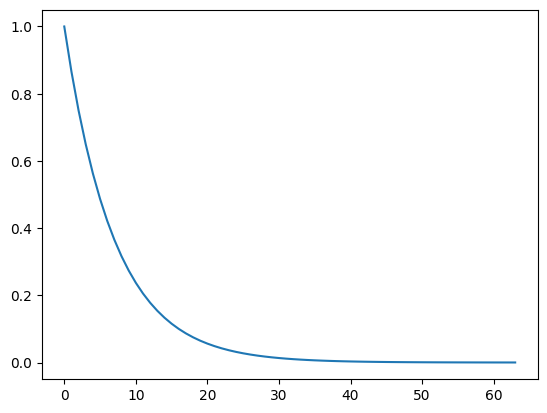

In [9]:
plt.plot(inv_freq);

In [10]:
# stride the time steps
sequence_len = 1024 # again, easier to see with a bigger number
t = torch.arange(sequence_len, dtype=torch.float32); t

tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.0210e+03, 1.0220e+03,
        1.0230e+03])

In [11]:
# calculate the rotation frequences at each (time, channel) pair
freqs = torch.outer(t, inv_freq); freqs.size() # expect 2x2 tensor

torch.Size([1024, 64])

In [12]:
cos, sin = freqs.cos(), freqs.sin()

In [13]:
cos

tensor([[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.6479,  0.7318,  ...,  1.0000,  1.0000,  1.0000],
        [-0.4161, -0.1604,  0.0709,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.9998, -0.2072,  0.6164,  ...,  0.9877,  0.9907,  0.9931],
        [-0.5550,  0.6109,  0.9877,  ...,  0.9876,  0.9907,  0.9930],
        [ 0.4001,  0.9989,  0.8292,  ...,  0.9876,  0.9907,  0.9930]])

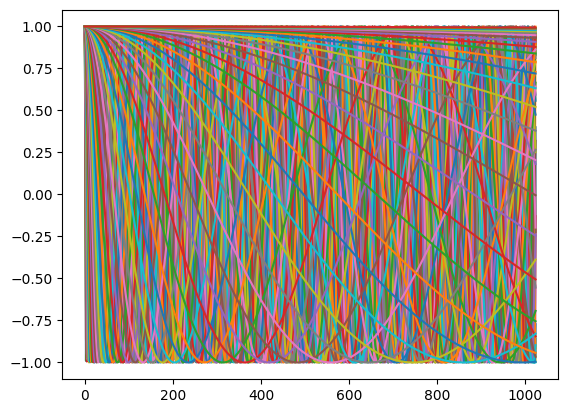

In [14]:
# plot values for all positions (0-999) for all channels
plt.plot(cos);

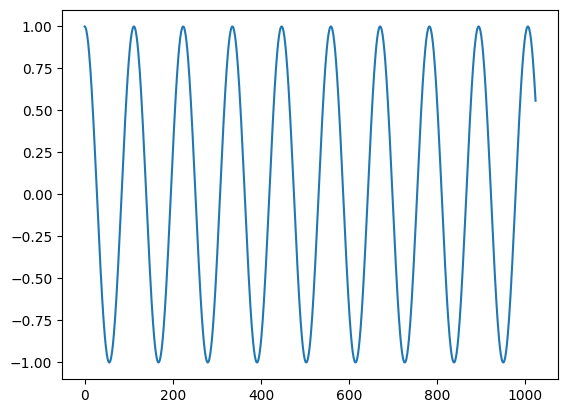

In [15]:
# plot values for all positions for just channel 20
plt.plot(cos[:,20]);

Believe the very rough intuition is that some operations (e.g. multiplications) involving position ~390 in the sequence and 20 in the head (???) will use ~ -0.99 and ~415 will use ~ -0.25 and this adds positional information. Hopefully will understand this better as I go along. Also still don't get why we want head_dim / 2. Ah, glancing at `apply_rotary_embed()`, I see it has something to do with splitting the head in half and using cos for half and sin for the other half.

Another thing I don't get but hope to later is is how "aboslute" vs "relative" this stuff is. In challenge 9 I saw that we just fill the whole batch with tokens in order, so I don't think position 0 in each entry of the batch has any special meaning during training, but during generation it looks like we do line up the start of the sequence. I must be missing something about how training and/or generation actually works. Revisit.

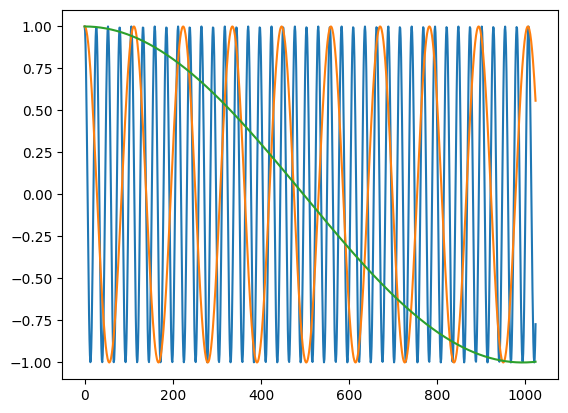

In [16]:
plt.plot(torch.stack((cos[:,10], cos[:,20], cos[:,40]), dim=1));

In [17]:
def precompute_rotary_embeddings(seq_len, head_dim, base=10000):
    channel_range = torch.arange(0, head_dim, 2, dtype=torch.float32)
    inv_freq = 1.0 / (base ** (channel_range / head_dim))
    t = torch.arange(seq_len, dtype=torch.float32)
    freqs = torch.outer(t, inv_freq)
    cos, sin = freqs.cos(), freqs.sin()
    cos, sin = cos.bfloat16(), sin.bfloat16()
    cos, sin = cos[None, :, None, :], sin[None, :, None, :]
    return cos, sin

In [18]:
cos, sin = precompute_rotary_embeddings(sequence_len, head_dim)
cos.size(), sin.size()

(torch.Size([1, 1024, 1, 64]), torch.Size([1, 1024, 1, 64]))

In [19]:
cos, sin = precompute_rotary_embeddings(my_config.sequence_len, my_config.n_embd // my_config.n_head)
cos.size(), sin.size()

(torch.Size([1, 7, 1, 4]), torch.Size([1, 7, 1, 4]))

### apply_rotary_embed()

Sticking with trying to understand rotary embeddings more, I think it makes sense to look at `apply_rotary_embed(x, cos, sin)` which is used in the forward of the `CausalSelfAttention` module.

It receives an x with 4 dimensions. I assume these are (B, T, H, n_embd / n_head).

In other words, a batch of size B with each entry consisting of T "positions" split into H "heads" with each position represented by vectors of length n_embd/ n_head. For example, `x[0,0,0,:]` is a vector "representing" the first position of the first head of the first entry in the batch. (In my original mental model, possibly always wrong, rotary embeds were done once to the input at the front of the model to add position information to the "regular" embeddings \[that are fixed per token regardless of position\]. However, after working on more code below, I see here we apply it in every self attention layer and to q and k so I'm not sure what the correct intuition is for what each dimension of the input represents.)

In [20]:
# setting batch size to a small odd number to make it easy to spot in the dimensions
# and remind us we're working with a batch
B = 3 

In [21]:
x = torch.rand(B, my_config.sequence_len, my_config.n_head, my_config.n_embd // my_config.n_head)
x.size()

torch.Size([3, 7, 2, 8])

In [22]:
d = x.shape[3] // 2
d

4

In [23]:
x1, x2 = x[..., :d], x[..., d:] # splitting on last dimension so expect each to be (3,7,2,4)
x1.size()

torch.Size([3, 7, 2, 4])

In [24]:
y1 = x1 * cos + x2 * sin
y2 = x1 * (-sin) + x2 * cos
out = torch.cat([y1, y2], 3)
out.shape

torch.Size([3, 7, 2, 8])

In [25]:
def apply_rotary_emb(x, cos, sin):
    assert(x.ndim == 4)
    d = x.shape[3] // 2
    x1, x2 = x[..., :d], x[..., d:]
    y1 = x1 * cos + x2 * sin
    y2 = x1 * (-sin) + x2 * cos
    out = torch.cat([y1, y2], 3)
    return out.to(x.dtype)

In [26]:
torch.allclose(out, apply_rotary_emb(x, cos, sin))

True

Visualize what apply_rotary_emb does

In [27]:
# input where every "embedding" is just [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
x = torch.full((B, my_config.sequence_len, my_config.n_head, my_config.n_embd // my_config.n_head), 0.1)

In [28]:
def plot(x, vmin=-1.0, vmax=1.0):
    plt.figure(figsize=(3, 3))
    plt.ylabel(f"positions 0 - {x.shape[0]}")
    plt.xlabel(f"embedding entries 0 - {x.shape[1]}")
    plt.imshow(x, cmap='coolwarm', vmin=vmin, vmax=vmax)

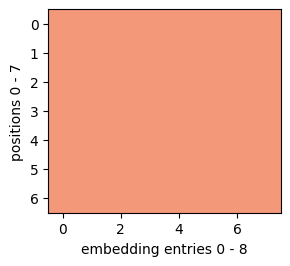

In [29]:
# plot first head of first item in batch
plot(x[0,:,0,:], -0.2, 0.2)

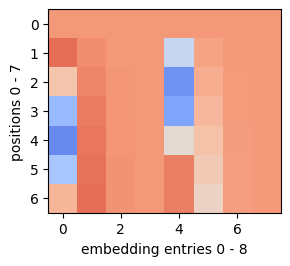

In [30]:
y = apply_rotary_emb(x, cos, sin)
plot(y[0,:,0,:], -0.2, 0.2)

In [31]:
# Why, for example, does the entire position 0 remain unchanged?
# because 0.1 * 1 + 0.1 * 0 = 0.1 and 0.1 * (-0) + 0.1 * 1 = 0.1
cos[0,0,0,:], sin[0,0,0,:]

(tensor([1., 1., 1., 1.], dtype=torch.bfloat16),
 tensor([0., 0., 0., 0.], dtype=torch.bfloat16))

But we can see that each position now has its own different vector.

In [32]:
# input where every "embedding" is linspace(-1,1)
x = torch.linspace(-1, 1, steps=my_config.n_embd // my_config.n_head).repeat(B, my_config.sequence_len, my_config.n_head, 1)
x.shape

torch.Size([3, 7, 2, 8])

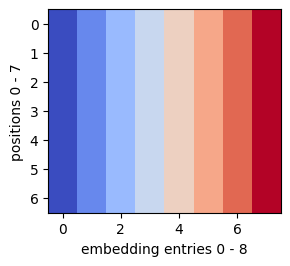

In [33]:
plot(x[0,:,0,:])

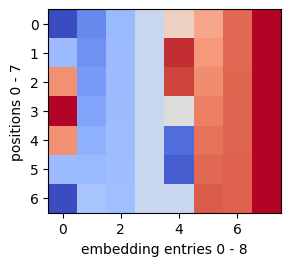

In [34]:
y = apply_rotary_emb(x, cos, sin)
plot(y[0,:,0,:])

Position 0 is unchanged, all other are changed, most dramatically in "embedding" elements 0 and 4 which makes sense

### CausalSelfAttention

Let's create a simplified version of the CausalSelfAttention module

In [35]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config, layer_idx):
        super().__init__()
        self.layer_idx = layer_idx
        self.n_head = config.n_head
        self.n_kv_head = config.n_kv_head
        self.n_embd = config.n_embd
        self.head_dim = self.n_embd // self.n_head
        assert self.n_embd % self.n_head == 0
        assert self.n_kv_head <= self.n_head and self.n_head % self.n_kv_head == 0
        # need to learn more about how it works / what it means when n_kv_head is not equal to number of heads
        # like won't it mean that the kv_heads will have larger dimensions so how does it all work out?
        
        self.c_q = nn.Linear(self.n_embd, self.n_head * self.head_dim, bias=False)
        # why does he express the out features as self.n_head * self.head_dim instead of self.n_embd?
        self.c_k = nn.Linear(self.n_embd, self.n_kv_head * self.head_dim, bias=False)
        self.c_v = nn.Linear(self.n_embd, self.n_kv_head * self.head_dim, bias=False)
        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)

Let's manually go through one simplified version of forward

In [36]:
csa = CausalSelfAttention(my_config, layer_idx=0)

In [37]:
x = torch.rand(B, my_config.sequence_len, my_config.n_embd)
x.size()

torch.Size([3, 7, 16])

In [38]:
B, T, C = x.size()

In [39]:
q = csa.c_q(x).view(B, T, csa.n_head, csa.head_dim)
k = csa.c_q(x).view(B, T, csa.n_kv_head, csa.head_dim)
v = csa.c_q(x).view(B, T, csa.n_kv_head, csa.head_dim)

q.shape, k.shape, v.shape # expect all to be (3,7,2,8)

(torch.Size([3, 7, 2, 8]), torch.Size([3, 7, 2, 8]), torch.Size([3, 7, 2, 8]))

In [40]:
q, k = apply_rotary_emb(q, cos, sin), apply_rotary_emb(k, cos, sin)
q.shape, k.shape # expect unchanged

(torch.Size([3, 7, 2, 8]), torch.Size([3, 7, 2, 8]))

Why do we apply rotary embeddings to q and k but not v? What if we applied it only to one? Or all three?

In [41]:
q, k = norm(q), norm(k)

In [42]:
q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
q.shape

torch.Size([3, 2, 7, 8])

Why do we want to go from (B, T, H, D) to (B, H, T, D)? I assume that will become clear.

Need to understand how the KV cache works. There's lots of code here related to that which I'll skip for now and focus on what we need during training where we don't have a cache.

In [43]:
y = F.scaled_dot_product_attention(q, k, v, is_causal=True, enable_gqa=False)

In [44]:
y.shape

torch.Size([3, 2, 7, 8])

I see, we needed to transpose so we could use F.scaled_dot_product_attention which expects T and D in the trailing dimensions

For fun, let's compute the scaled dot product attention using the description in the [torch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html)

In [45]:
L, S = q.size(-2), k.size(-2)
scale_factor = 1 / math.sqrt(q.size(-1))
attn_bias = torch.zeros(L, S, dtype=q.dtype)
temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
attn_weight = q @ k.transpose(-2, -1) * scale_factor
attn_weight += attn_bias
attn_weight = torch.softmax(attn_weight, dim=-1)
result = attn_weight @ v

In [46]:
torch.allclose(y, result)

True

Interesting that at least in this code which comes from the documentation, not the actual implementation, the mask is applied by adding to -inf. I would have though it would be by multiplying by 0.

Now back to the forward pass

In [47]:
y.shape

torch.Size([3, 2, 7, 8])

In [48]:
y = y.transpose(1,2).contiguous().view(B, T, -1) # so get back to (B, T, C)
y.shape

torch.Size([3, 7, 16])

Why does C (channel?) mean n_embd? Maybe because just like red, green, blue, alpha in images are channels each conveying a related but different type of information about each pixel, each channel here conveys something about the token.

In [49]:
y = csa.c_proj(y)
y.shape

torch.Size([3, 7, 16])

Now put the whole class together

In [50]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config, layer_idx):
        super().__init__()
        self.layer_idx = layer_idx
        self.n_head = config.n_head
        self.n_kv_head = config.n_kv_head
        self.n_embd = config.n_embd
        self.head_dim = self.n_embd // self.n_head
        assert self.n_embd % self.n_head == 0
        assert self.n_kv_head <= self.n_head and self.n_head % self.n_kv_head == 0
        # need to learn more about how it works / what it means when n_kv_head is not equal to number of heads
        # like won't it mean that the kv_heads will have larger dimensions so how does it all work out?
        
        self.c_q = nn.Linear(self.n_embd, self.n_head * self.head_dim, bias=False)
        # why does he express out features as self.n_head * self.head_dim instead of self.n_embd?
        self.c_k = nn.Linear(self.n_embd, self.n_kv_head * self.head_dim, bias=False)
        self.c_v = nn.Linear(self.n_embd, self.n_kv_head * self.head_dim, bias=False)
        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)

    # this is the limited forward copying the code from above that assumes no kv_cache
    def forward(self, x, cos_sin, kv_cache=None):
        assert(kv_cache is None)
        B, T, C = x.size()
        
        q = self.c_q(x).view(B, T, self.n_head, self.head_dim)
        k = self.c_q(x).view(B, T, self.n_kv_head, self.head_dim)
        v = self.c_q(x).view(B, T, self.n_kv_head, self.head_dim)

        cos, sin = cos_sin
        q, k = apply_rotary_emb(q, cos, sin), apply_rotary_emb(k, cos, sin)
        q, k = norm(q), norm(k)

        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        y = F.scaled_dot_product_attention(q, k, v, is_causal=True, enable_gqa=False)
        y = y.transpose(1,2).contiguous().view(B, T, -1)
        y = self.c_proj(y)
        return y    

In [51]:
csa = CausalSelfAttention(my_config, layer_idx=0)
y = csa(x, (cos, sin))
y.shape

torch.Size([3, 7, 16])

### MLP

In [52]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=False) # c_fc = channel/component fullly connected
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=False)
        # how come we don't want bias here and above?

    def forward(self, x):
        x = self.c_fc(x)
        x = F.relu(x).square() # why square? Is this a more recent technique?
        x = self.c_proj(x)
        return x

In [53]:
mlp = MLP(my_config)
mlp(x).shape

torch.Size([3, 7, 16])

### Block

In [54]:
class Block(nn.Module):
    def __init__(self, config, layer_idx):
        super().__init__()
        self.attn = CausalSelfAttention(config, layer_idx)
        self.mlp = MLP(config)

    def forward(self, x, cos_sin, kv_cache):
        assert(kv_cache is None)
        # Why are residual connections ok when training? I guess because the only time we "mix" positions
        # is in causal self attention so it still can't cheat
        x = x + self.attn(norm(x), cos_sin)
        x = x + self.mlp(norm(x))
        return x

In [55]:
block = Block(my_config, 0)
y = block(x, (cos, sin), None)
y.shape

torch.Size([3, 7, 16])

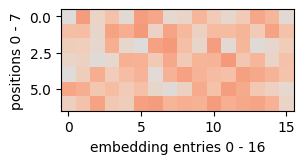

In [56]:
plot(x[0,:,:], vmin=-2.0, vmax=2.0)

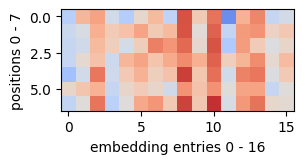

In [57]:
plot(y.detach()[0,:,:], vmin=-2.0, vmax=2.0)

With the residual connections we do expect input and output to look similar

### GPT

Now we can actually create our simplified GPT class and try the forward pass in training mode (still with randomly initalized weights)

In [58]:
class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict({
            "wte": nn.Embedding(config.vocab_size, config.n_embd), # wte = word token embeddings
            "h": nn.ModuleList([Block(config, layer_idx) for layer_idx in range(config.n_layer)]), # h = hidden states
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # = lm = language modeling
        # in the actual code there is a note about how rotary precompute is "fake" here and happens for
        # real in init_weights() but for this simplified class we'll just do once "for real" here
        self.rotary_seq_len = config.sequence_len * 10
        # hmm, so my example computing above wasn't right, maybe it doesn't matter because it's periodic?
        # play with that below
        head_dim = config.n_embd // config.n_head
        cos, sin = precompute_rotary_embeddings(self.rotary_seq_len, head_dim)
        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)

In [59]:
gpt = GPT(my_config); gpt

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(10, 16)
    (h): ModuleList(
      (0-1): 2 x Block(
        (attn): CausalSelfAttention(
          (c_q): Linear(in_features=16, out_features=16, bias=False)
          (c_k): Linear(in_features=16, out_features=16, bias=False)
          (c_v): Linear(in_features=16, out_features=16, bias=False)
          (c_proj): Linear(in_features=16, out_features=16, bias=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=16, out_features=64, bias=False)
          (c_proj): Linear(in_features=64, out_features=16, bias=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=16, out_features=10, bias=False)
)

#### Now let's step through `forward()` in training mode

In [60]:
B = 3

In [61]:
T = my_config.sequence_len; T

7

Make up random input / targets

In [62]:
temp = torch.randint(low=0, high=my_config.vocab_size, size=(B, T+1)); temp

tensor([[4, 9, 0, 5, 0, 9, 8, 0],
        [9, 6, 2, 6, 9, 1, 1, 6],
        [1, 2, 1, 7, 2, 4, 4, 2]])

In [63]:
idx = temp[:,0:-1]; idx

tensor([[4, 9, 0, 5, 0, 9, 8],
        [9, 6, 2, 6, 9, 1, 1],
        [1, 2, 1, 7, 2, 4, 4]])

In [64]:
targets = temp[:,1:].clone(); targets

tensor([[9, 0, 5, 0, 9, 8, 0],
        [6, 2, 6, 9, 1, 1, 6],
        [2, 1, 7, 2, 4, 4, 2]])

In [65]:
idx.shape, targets.shape

(torch.Size([3, 7]), torch.Size([3, 7]))

In [66]:
B, T = idx.size()
B, T

(3, 7)

In [67]:
cos_sin = gpt.cos[:,:T], gpt.sin[:,:T]
cos_sin[0].shape

torch.Size([1, 7, 1, 4])

In [68]:
x = gpt.transformer.wte(idx); x.shape # expect (B, T, C)

torch.Size([3, 7, 16])

In [69]:
x = norm(x)
for block in gpt.transformer.h:
    x = block(x, cos_sin, kv_cache=None)
x = norm(x)
x.shape

torch.Size([3, 7, 16])

In [70]:
logits = gpt.lm_head(x); logits.shape # expect (B, T, vocab_size)

torch.Size([3, 7, 10])

In [71]:
logits[0,0,:]

tensor([-0.6875,  1.0273, -0.1407, -0.0071,  0.7848, -0.2552,  0.5313, -0.1294,
        -0.0679,  0.7455], grad_fn=<SelectBackward0>)

In [72]:
softcap = 15
logits = softcap * torch.tanh(logits / softcap)

In [73]:
logits[0,0,:]

tensor([-0.6870,  1.0257, -0.1407, -0.0071,  0.7841, -0.2552,  0.5310, -0.1294,
        -0.0679,  0.7449], grad_fn=<SelectBackward0>)

What is softcap? chatgpt: “Logit soft-cap” (sometimes written “soft-capping of logits”) is a technique used in modern deep learning models—especially large language models—to prevent the raw prediction scores (“logits”) from growing unboundedly large, but without simply clipping them sharply.

In [74]:
temp_x = torch.linspace(-30, 30, steps=1000)

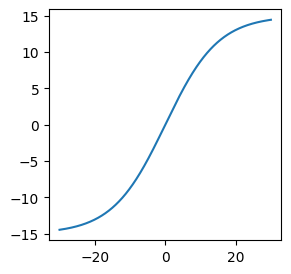

In [75]:
plt.figure(figsize=(3, 3))
plt.plot(temp_x, softcap * torch.tanh(temp_x / softcap));

In [76]:
logits = logits.float()

In [77]:
logits.view(-1, logits.size(-1)).shape

torch.Size([21, 10])

In [78]:
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1, reduction='mean')

In [79]:
loss

tensor(2.3162, grad_fn=<NllLossBackward0>)

Sanity check - pretend we got all right (even with low confidence) and calculate the loss

In [80]:
fake_targets = torch.argmax(logits, dim=-1); fake_targets

tensor([[1, 4, 4, 6, 4, 4, 8],
        [4, 2, 2, 2, 4, 6, 6],
        [6, 2, 6, 4, 4, 1, 1]])

In [81]:
F.cross_entropy(logits.view(-1, logits.size(-1)), fake_targets.view(-1), ignore_index=-1, reduction='mean')

tensor(1.5381, grad_fn=<NllLossBackward0>)

### GPT class with forward

Put the above together so we can use forward() to generate

In [82]:
class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict({
            "wte": nn.Embedding(config.vocab_size, config.n_embd), # wte = word token embeddings
            "h": nn.ModuleList([Block(config, layer_idx) for layer_idx in range(config.n_layer)]), # h = hidden states
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # = lm = language modeling
        # in the actual code there is a note about how rotary precompute is "fake" here and happens for
        # real in init_weights() but for this simplified class we'll just do once "for real" here
        self.rotary_seq_len = config.sequence_len * 10
        head_dim = config.n_embd // config.n_head
        cos, sin = precompute_rotary_embeddings(self.rotary_seq_len, head_dim)
        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)

    def forward(self, idx, targets=None, kv_cache=None):
        B, T = idx.size()
        cos_sin = self.cos[:,:T], gpt.sin[:,:T]
        x = self.transformer.wte(idx)
        x = norm(x)
        for block in self.transformer.h:
            x = block(x, cos_sin, kv_cache=None)
        x = norm(x)
        logits = self.lm_head(x)
        softcap = 15
        logits = softcap * torch.tanh(logits / softcap)
        if targets is not None:
            logits = self.lm_head(x)
            logits = logits.float()
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1, reduction='mean')
            return loss
        else:
            return logits

In [83]:
gpt = GPT(my_config)

In [84]:
# training mode
loss = gpt(idx, targets); loss

tensor(2.4724, grad_fn=<NllLossBackward0>)

In [85]:
# inference mode
logits = gpt(idx); logits.shape # expect (B, T, vocab_size)

torch.Size([3, 7, 10])

#### step through simplified generate()

This is just to get a rough idea. I didn't implement the inference code in CausalSelfAttention.forward above.

In [86]:
tokens = [0]

In [87]:
ids = torch.tensor([tokens], dtype=torch.long); ids

tensor([[0]])

In [88]:
max_tokens = 5

In [89]:
for _ in range(max_tokens):
    logits = gpt.forward(ids)
    logits = logits[:,-1,:] # the last ones
    next_ids = torch.argmax(logits, dim=-1, keepdim=True)
    ids = torch.cat((ids, next_ids), dim=-1)
    print(ids)

tensor([[0, 1]])
tensor([[0, 1, 5]])
tensor([[0, 1, 5, 4]])
tensor([[0, 1, 5, 4, 2]])
tensor([[0, 1, 5, 4, 2, 5]])


### I'll now create `my_gpt.py`

In [90]:
import sys
sys.path.append('../my_nanochat')

In [91]:
from my_nanochat.my_gpt import GPTConfig, GPT
import torch

In [92]:
my_config = GPTConfig(
    sequence_len=7,
    vocab_size=10,
    n_layer=2,
    n_head=2,
    n_kv_head=2,
    n_embd=16,
)

In [93]:
gpt = GPT(my_config)

In [94]:
gpt

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(10, 16)
    (h): ModuleList(
      (0-1): 2 x Block(
        (attn): CausalSelfAttention(
          (c_q): Linear(in_features=16, out_features=16, bias=False)
          (c_k): Linear(in_features=16, out_features=16, bias=False)
          (c_v): Linear(in_features=16, out_features=16, bias=False)
          (c_proj): Linear(in_features=16, out_features=16, bias=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=16, out_features=64, bias=False)
          (c_proj): Linear(in_features=64, out_features=16, bias=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=16, out_features=10, bias=False)
)

In [95]:
# fake inputs and targets
temp = torch.randint(low=0, high=my_config.vocab_size, size=(3, 8)) # B, T+1
idx = temp[:,0:-1]
targets = temp[:,1:].clone()
idx, targets

(tensor([[7, 6, 0, 3, 6, 0, 1],
         [6, 9, 0, 4, 6, 6, 7],
         [8, 9, 6, 6, 1, 4, 7]]),
 tensor([[6, 0, 3, 6, 0, 1, 5],
         [9, 0, 4, 6, 6, 7, 1],
         [9, 6, 6, 1, 4, 7, 4]]))

In [96]:
gpt(idx, targets)

tensor(2.3907, grad_fn=<NllLossBackward0>)

In [97]:
gpt(idx).shape

torch.Size([3, 7, 10])

### Back to precompute_rotary_embeddings

See that it doesn't matter how long a sequence we precompute, the values for a given channel for a given position in the sequence will be the same. The periodicity depends on the number of channels, not the length of the sequence. 

In [98]:
cos1000, sin100 = precompute_rotary_embeddings(1_000, 128)
cos10000, sin1000 = precompute_rotary_embeddings(10_000, 128)

In [99]:
cos1000.shape

torch.Size([1, 1000, 1, 64])

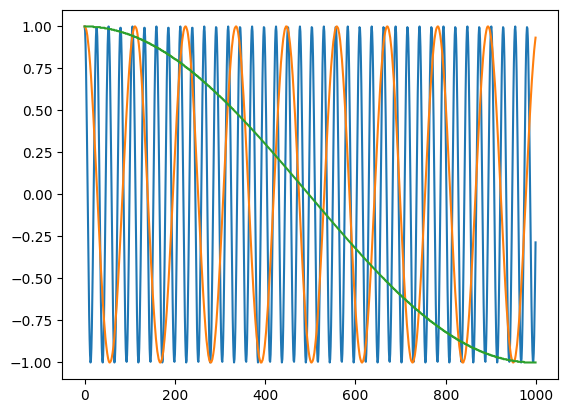

In [100]:
# plot values for all positions (0-999) for channels 10, 20, and 40
plt.plot(torch.stack((cos1000[0,:,0,10], cos1000[0,:,0,20], cos1000[0,:,0,40]), dim=1).to(torch.float32));

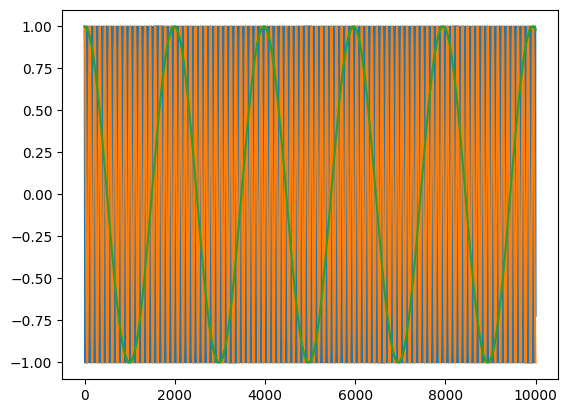

In [101]:
# plot values for all positions (0-9999) for channels 10, 20, and 40
plt.plot(torch.stack((cos10000[0,:,0,10], cos10000[0,:,0,20], cos10000[0,:,0,40]), dim=1).to(torch.float32));

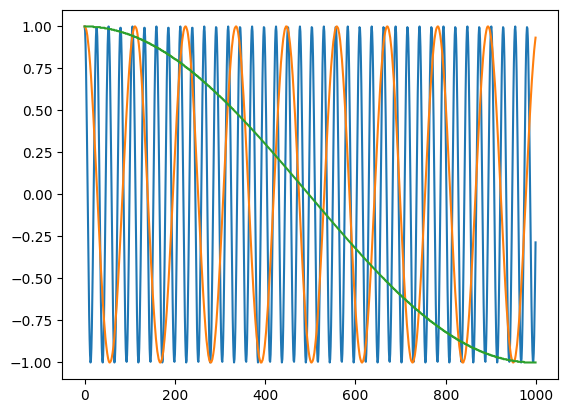

In [102]:
# to see it's the same for 0-999, plot values for just positions (0-999) for channels 10, 20, and 40
plt.plot(torch.stack((cos10000[0,:,0,10], cos10000[0,:,0,20], cos10000[0,:,0,40]), dim=1).to(torch.float32)[:1000]);